In [ ]:
!git clone https://huggingface.co/spaces/InstantX/InstantID/

In [1]:
%cd /kaggle/working/InstantID

/kaggle/working/InstantID


In [ ]:
!pip install -r requirements.txt

In [2]:
import cv2
import torch
import random
import numpy as np
import os
import spaces

import PIL
from PIL import Image
from typing import Tuple

import diffusers
from diffusers.utils import load_image
from diffusers.models import ControlNetModel
from diffusers.pipelines.controlnet.multicontrolnet import MultiControlNetModel

from huggingface_hub import hf_hub_download

from insightface.app import FaceAnalysis

from style_template import styles
from pipeline_stable_diffusion_xl_instantid_full import StableDiffusionXLInstantIDPipeline, draw_kps

from controlnet_aux import OpenposeDetector


from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

import torch.nn.functional as F
from torchvision.transforms import Compose

2024-02-11 14:03:08.335168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 14:03:08.335230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 14:03:08.339242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_

In [3]:
DEFAULT_STYLE_NAME = "(No style)"
DEBUG = False
DATA_PATH = "/kaggle/input/male-and-female-faces-dataset"
MAX_SEED = np.iinfo(np.int32).max
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if str(device).__contains__("cuda") else torch.float32
enable_lcm_arg = False
STYLE_NAMES = list(styles.keys())

In [4]:
hf_hub_download(repo_id="InstantX/InstantID", filename="ControlNetModel/config.json", local_dir="./checkpoints")
hf_hub_download(
    repo_id="InstantX/InstantID",
    filename="ControlNetModel/diffusion_pytorch_model.safetensors",
    local_dir="./checkpoints",
)
hf_hub_download(repo_id="InstantX/InstantID", filename="ip-adapter.bin", local_dir="./checkpoints")

# Load face encoder
app = FaceAnalysis(
    name="antelopev2",
    root="./",
    providers=["CPUExecutionProvider"],
)
app.prepare(ctx_id=0, det_size=(640, 640))

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_vitl14').to(device).eval()

transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

# Path to InstantID models
face_adapter = f"./checkpoints/ip-adapter.bin"
controlnet_path = f"./checkpoints/ControlNetModel"

# Load pipeline face ControlNetModel
controlnet_identitynet = ControlNetModel.from_pretrained(
    controlnet_path, torch_dtype=dtype
)

# controlnet-pose/canny/depth
#controlnet_pose_model = "thibaud/controlnet-openpose-sdxl-1.0"
#controlnet_canny_model = "diffusers/controlnet-canny-sdxl-1.0"
#controlnet_depth_model = "diffusers/controlnet-depth-sdxl-1.0-small"

#controlnet_pose = ControlNetModel.from_pretrained(
#    controlnet_pose_model, torch_dtype=dtype
#).to(device)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)


In [ ]:
#controlnet_canny = ControlNetModel.from_pretrained(
#    controlnet_canny_model, torch_dtype=dtype
#).to(device)
#controlnet_depth = ControlNetModel.from_pretrained(
#    controlnet_depth_model, torch_dtype=dtype
#).to(device)

In [5]:
def get_depth_map(image):
    
    image = np.array(image) / 255.0

    h, w = image.shape[:2]

    image = transform({'image': image})['image']
    image = torch.from_numpy(image).unsqueeze(0).to("cuda")

    with torch.no_grad():
        depth = depth_anything(image)

    depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0

    depth = depth.cpu().numpy().astype(np.uint8)

    depth_image = Image.fromarray(depth)

    return depth_image

'''
def get_canny_image(image, t1=100, t2=200):
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    edges = cv2.Canny(image, t1, t2)
    return Image.fromarray(edges, "L")'''

'''controlnet_map = {
    "pose": controlnet_pose,
    "canny": controlnet_canny,
    "depth": controlnet_depth,
}
controlnet_map_fn = {
    "pose": openpose,
    "canny": get_canny_image,
    "depth": get_depth_map,
}'''

pretrained_model_name_or_path = "wangqixun/YamerMIX_v8"

pipe = StableDiffusionXLInstantIDPipeline.from_pretrained(
    pretrained_model_name_or_path,
    controlnet=[controlnet_identitynet],
    torch_dtype=dtype,
    safety_checker=None,
    feature_extractor=None,
).to(device)

pipe.scheduler = diffusers.EulerDiscreteScheduler.from_config(
    pipe.scheduler.config
)

# load and disable LCM
pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl")
pipe.disable_lora()

pipe.cuda()
pipe.load_ip_adapter_instantid(face_adapter)
pipe.image_proj_model.to("cuda")
pipe.unet.to("cuda")

The config attributes {'controlnet_list': ['controlnet', 'RPMultiControlNetModel'], 'requires_aesthetics_score': False} were passed to StableDiffusionXLInstantIDPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'controlnet_list': ['controlnet', 'RPMultiControlNetModel'], 'requires_aesthetics_score': False, 'safety_checker': None} are not expected by StableDiffusionXLInstantIDPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/394M [00:00<?, ?B/s]

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (add_time_proj): Timesteps()
  (add_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=2816, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 320, eps=1e-05, affine=True)
          (conv1): lora.Conv2d(
            (base_layer): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (lora_dropout): ModuleDict(
              (default_0): Identity()
            )
            (lora_A): ModuleDict(
         

In [14]:
def random_seed() -> int:
    return random.randint(0, MAX_SEED)


def convert_from_cv2_to_image(img: np.ndarray) -> Image:
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def convert_from_image_to_cv2(img: Image) -> np.ndarray:
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

def resize_img(
    input_image,
    max_side=1280,
    min_side=1024,
    size=None,
    pad_to_max_side=False,
    mode=PIL.Image.BILINEAR,
    base_pixel_number=64,
):
    w, h = input_image.size
    if size is not None:
        w_resize_new, h_resize_new = size
    else:
        ratio = min_side / min(h, w)
        w, h = round(ratio * w), round(ratio * h)
        ratio = max_side / max(h, w)
        input_image = input_image.resize([round(ratio * w), round(ratio * h)], mode)
        w_resize_new = (round(ratio * w) // base_pixel_number) * base_pixel_number
        h_resize_new = (round(ratio * h) // base_pixel_number) * base_pixel_number
    input_image = input_image.resize([w_resize_new, h_resize_new], mode)

    if pad_to_max_side:
        res = np.ones([max_side, max_side, 3], dtype=np.uint8) * 255
        offset_x = (max_side - w_resize_new) // 2
        offset_y = (max_side - h_resize_new) // 2
        res[
            offset_y : offset_y + h_resize_new, offset_x : offset_x + w_resize_new
        ] = np.array(input_image)
        input_image = Image.fromarray(res)
    return input_image

def apply_style(
    style_name: str, positive: str, negative: str = ""
) -> Tuple[str, str]:
    p, n = styles.get(style_name, styles[DEFAULT_STYLE_NAME])
    return p.replace("{prompt}", positive), n + " " + negative


@torch.no_grad()
def generate_image(
    face_image_path,
    prompt,
    pose_image_path = '',
    negative_prompt="(lowres, low quality, worst quality:1.2), (text:1.2), watermark, (frame:1.2), deformed, ugly, deformed eyes, blur, out of focus, blurry, deformed cat, deformed, photo, anthropomorphic cat, monochrome, pet collar, gun, weapon, blue, 3d, drones, drone, buildings in background, green",
    style_name=DEFAULT_STYLE_NAME,
    num_steps=30,
    identitynet_strength_ratio=0.8,
    adapter_strength_ratio=0.8,
    pose_strength=0.4,
    canny_strength=0.4,
    depth_strength=0.4,
    controlnet_selection=[],
    guidance_scale=5.0,
    seed=random_seed(),
    scheduler='EulerDiscreteScheduler',
    enable_LCM=False,
    enhance_face_region=True,
):

    if enable_LCM:
        pipe.scheduler = diffusers.LCMScheduler.from_config(pipe.scheduler.config)
        pipe.enable_lora()
    else:
        pipe.disable_lora()
        scheduler_class_name = scheduler.split("-")[0]

        add_kwargs = {}
        if len(scheduler.split("-")) > 1:
            add_kwargs["use_karras_sigmas"] = True
        if len(scheduler.split("-")) > 2:
            add_kwargs["algorithm_type"] = "sde-dpmsolver++"
        scheduler = getattr(diffusers, scheduler_class_name)
        pipe.scheduler = scheduler.from_config(pipe.scheduler.config, **add_kwargs)

    if not os.path.exists(face_image_path):
        raise Exception(
            f"Cannot find any input face image! Please upload the face image"
        )

    assert prompt

    prompt, negative_prompt = apply_style(style_name, prompt, negative_prompt)

    face_image = load_image(face_image_path)
    face_image = resize_img(face_image, max_side=1024)
    face_image_cv2 = convert_from_image_to_cv2(face_image)
    height, width, _ = face_image_cv2.shape

    # Extract face features
    face_info = app.get(face_image_cv2)

    if len(face_info) == 0:
        raise Exception(
            f"Unable to detect a face in the image. Please upload a different photo with a clear face."
        )

    face_info = sorted(
        face_info,
        key=lambda x: (x["bbox"][2] - x["bbox"][0]) * x["bbox"][3] - x["bbox"][1],
    )[
        -1
    ] 
    face_emb = face_info["embedding"]
    face_kps = draw_kps(convert_from_cv2_to_image(face_image_cv2), face_info["kps"])
    img_controlnet = face_image
    
    if os.path.exists(pose_image_path):
        pose_image = load_image(pose_image_path)
        pose_image = resize_img(pose_image, max_side=1024)
        img_controlnet = pose_image
        pose_image_cv2 = convert_from_image_to_cv2(pose_image)

        face_info = app.get(pose_image_cv2)

        if len(face_info) == 0:
            raise Exception(
                f"Cannot find any face in the reference image! Please upload another person image"
            )

        face_info = face_info[-1]
        face_kps = draw_kps(pose_image, face_info["kps"])

        width, height = face_kps.size

    if enhance_face_region:
        control_mask = np.zeros([height, width, 3])
        x1, y1, x2, y2 = face_info["bbox"]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        control_mask[y1:y2, x1:x2] = 255
        control_mask = Image.fromarray(control_mask.astype(np.uint8))
    else:
        control_mask = None

    if len(controlnet_selection) > 0:
        controlnet_scales = {
            "pose": pose_strength,
            "canny": canny_strength,
            "depth": depth_strength,
        }
        pipe.controlnet = MultiControlNetModel(
            [controlnet_identitynet]
            + [controlnet_map[s] for s in controlnet_selection]
        )
        control_scales = [float(identitynet_strength_ratio)] + [
            controlnet_scales[s] for s in controlnet_selection
        ]
        control_images = [face_kps] + [
            controlnet_map_fn[s](img_controlnet).resize((width, height))
            for s in controlnet_selection
        ]
    else:
        pipe.controlnet = controlnet_identitynet
        control_scales = float(identitynet_strength_ratio)
        control_images = face_kps

    generator = torch.Generator(device=device).manual_seed(seed)

    print("Start inference...")
    print(f"[Debug] Prompt: {prompt}, \n[Debug] Neg Prompt: {negative_prompt}")

    pipe.set_ip_adapter_scale(adapter_strength_ratio)
    images = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image_embeds=face_emb,
        image=control_images,
        control_mask=control_mask,
        controlnet_conditioning_scale=control_scales,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
        height=height,
        width=width,
        generator=generator,
    ).images

    return images[0]

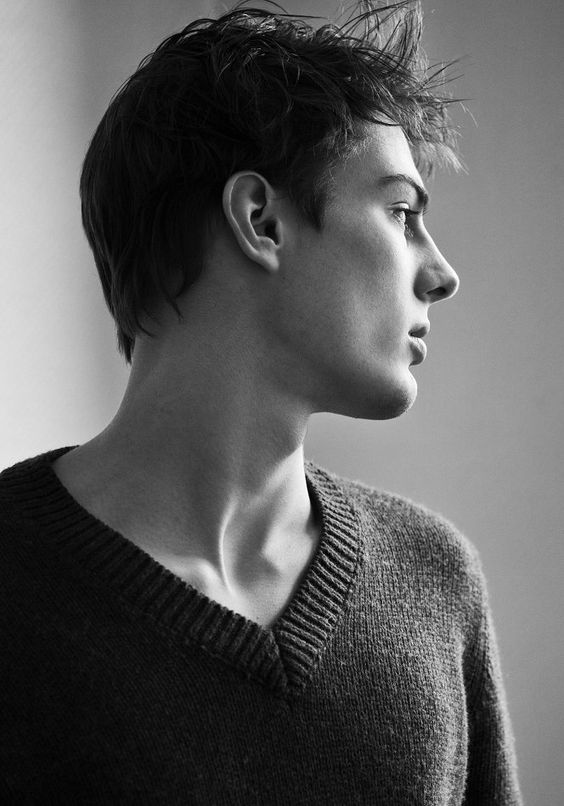

Start inference...
[Debug] Prompt: a sticker of a man, 
[Debug] Neg Prompt:  (lowres, low quality, worst quality:1.2), (text:1.2), watermark, (frame:1.2), deformed, ugly, deformed eyes, blur, out of focus, blurry, deformed cat, deformed, photo, anthropomorphic cat, monochrome, pet collar, gun, weapon, blue, 3d, drones, drone, buildings in background, green


  0%|          | 0/30 [00:00<?, ?it/s]

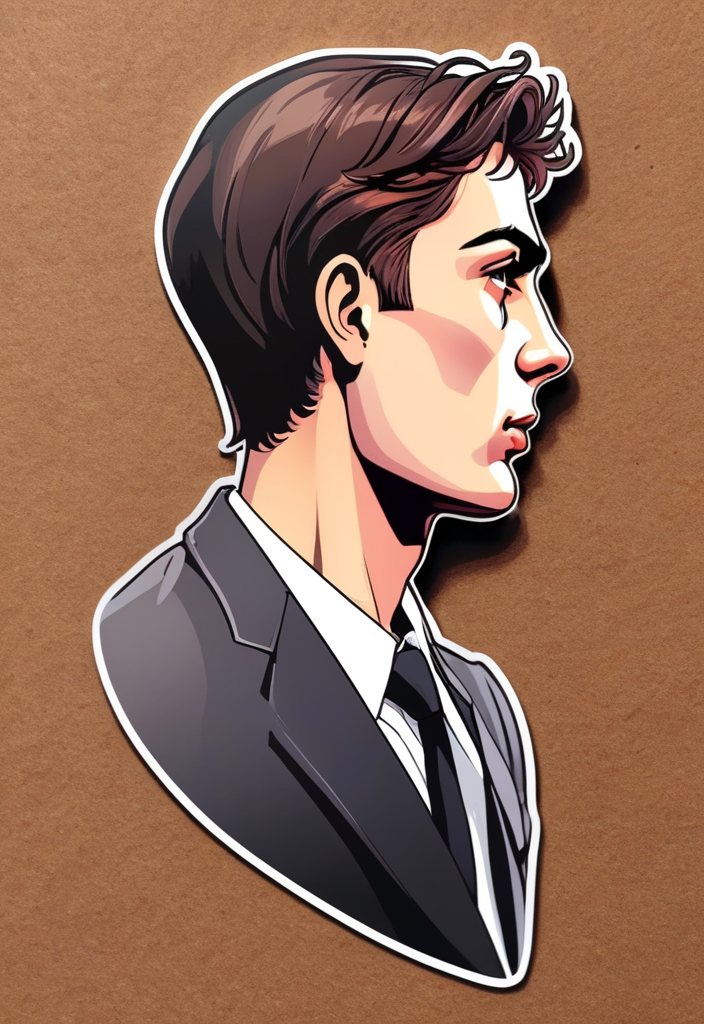

In [15]:
path = f'/kaggle/input/male-and-female-faces-dataset/Male and Female face dataset/Male Faces/{male[0]}'
display(Image.open(path))
img = generate_image(path, 'a sticker of a man')
img